In [240]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point

In [241]:
# uploading DOT's table that connects IDs between various datasets (DOT, OTI, Open Data, LION)
# matches non-highway collisions in the Open Data collisions dataset to nearest intersection 
# matching to intersections because pre-2016, NYPD almost excluslively placed collisions in nearest intersections, not on streets
# in order to avoid false trends (e.g. "drop" in intersection collisions), just collapsing all collisions across time to nearest intersection
# uses masterid, which is a DOT-modified equivalent to LION node IDs, to identify the intersection
# for example, some nodes in complex intersections are collapsed to a single masterid/ location
dot_collisions_key_part1 = pd.read_csv('../data/input/dot_data/crashes_w_int_ids_part1_20250204.csv')
dot_collisions_key_part2 = pd.read_csv('../data/input/dot_data/crashes_w_int_ids_part2_20250204.csv')
# combining to create 2013-2024
dot_collisions_key = pd.concat([dot_collisions_key_part1,dot_collisions_key_part2])

# removing crashes that only involve non-vehicles
dot_veh_collisions_key = dot_collisions_key[dot_collisions_key['nonmv'] == False]
dot_veh_collisions_key = dot_veh_collisions_key.drop(columns=['nonmv']) # dropping, no longer needed
dot_veh_collisions_key = dot_veh_collisions_key.reset_index().drop(columns=['index'])

<Axes: xlabel='crash_date'>

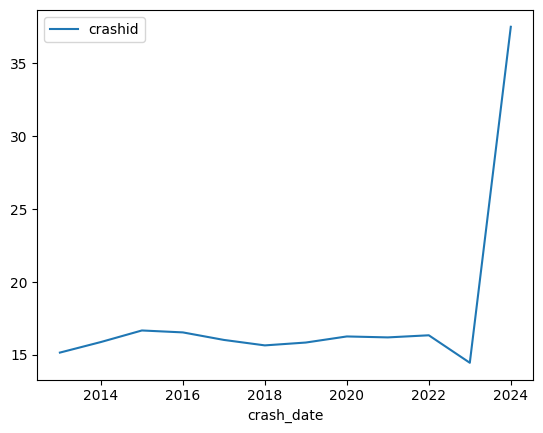

In [242]:
# visualizing missing masterid values over time 
# should probably drop 2024 (big spike in rows with missing master IDs, which makes it impossible to tie them to LION intersections)
# otherwise, the number that will be dropped due to missing location data is consistent across years (could be highway collisions)
# hopefully the consistency over time will prevent the data from being skewed by missing IDs

dot_veh_collisions_key['crash_date'] = pd.to_datetime(dot_veh_collisions_key['crash_date'])
(100*dot_veh_collisions_key[dot_veh_collisions_key['masterid'].isnull()].groupby(dot_veh_collisions_key['crash_date'].dt.year).count()[['crashid']] / dot_veh_collisions_key.groupby(dot_veh_collisions_key['crash_date'].dt.year).count()[['crashid']]).plot()

In [243]:
# adding lat/ lon to dot_veh_collisions_key based on masterid (using DOT provided key)

masterids = pd.read_csv('../data/input/dot_data/masterid_geom_20250204.csv')
masterids['master_geom'] = [Point(xy) for xy in zip(masterids.x, masterids.y)] 
# masterids['master_geom'] = masterids['master_geom'].apply(wkt.loads)
# create a GeoDataFrame
masterids_gdf = gpd.GeoDataFrame(masterids, geometry='master_geom') 
# set to (EPSG:2263 NAD83 / New York Long Island)
masterids_gdf.crs = "2263" 
dot_veh_collisions_key = dot_veh_collisions_key.merge(masterids_gdf[['masterid', 'master_geom']], on='masterid', how='left')

In [244]:
# Open Data crashes dataset

# pull from API 
# open_data_veh_collisions = pd.read_csv('https://data.cityofnewyork.us/resource/h9gi-nx95.csv?$select=collision_id,crash_date,crash_time,latitude,longitude,on_street_name,cross_street_name,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed&$limit=9999999')
# # saving 
# open_data_veh_collisions.to_csv('../data/output/open-data_vehicle-collision-dataset.csv', index = False) # saving as csv

# upload csv if not using API
open_data_veh_collisions = pd.read_csv('../data/output/open-data_vehicle-collision-dataset.csv') 

open_data_veh_collisions['crash_date'] = pd.to_datetime(open_data_veh_collisions['crash_date'])
open_data_veh_collisions['quarter'] = pd.PeriodIndex(open_data_veh_collisions.crash_date, freq='Q').astype(str)

<Axes: xlabel='crash_date'>

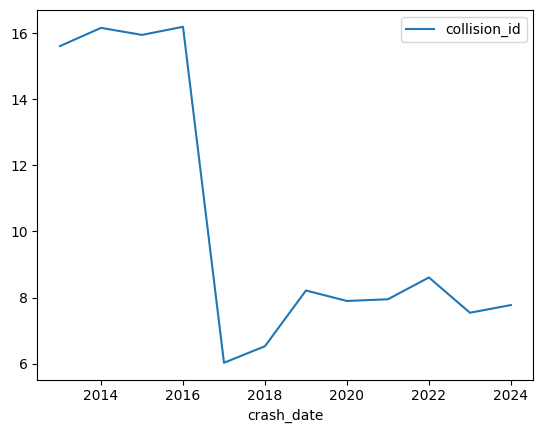

In [245]:
# visualizing missing values over time (missing geocoding)

v = open_data_veh_collisions[(open_data_veh_collisions['latitude'].isnull()) & (open_data_veh_collisions['crash_date'].dt.year.isin(list(range(2013,2025))))] 
(100*v[v['latitude'].isnull()].groupby(v['crash_date'].dt.year).count()[['collision_id']] / open_data_veh_collisions.groupby(open_data_veh_collisions['crash_date'].dt.year).count()[['collision_id']]).plot()

In [246]:
# merging Open Data collisions dataset with columns provided by DOT that link crashes to other datasets

merged_with_dot_key = open_data_veh_collisions.merge(dot_veh_collisions_key, left_on='collision_id', right_on='row_wid')
# only keeping entries whose dates match between DOT and Open Data datasets (very few affected by this drop, just a safeguard)
merged_with_dot_key = merged_with_dot_key[merged_with_dot_key['crash_date_x'] == merged_with_dot_key['crash_date_y']]
# keeping only one date column
merged_with_dot_key = merged_with_dot_key.drop(columns=['crash_date_y']).rename(columns={'crash_date_x':'crash_date'}) 
# dropping any null masterids (rows that never received matches or highways, which are excluded)
merged_with_dot_key = merged_with_dot_key[merged_with_dot_key['master_geom'].notnull()]

In [247]:
# creating a "total" column because cyclist and motorist collisions have not been consistently reported over the years
# preserving pedestrian outcomes (most consistent category), removing all other individual columns

merged_with_dot_key['total_injuries'] = merged_with_dot_key['number_of_pedestrians_injured'] + merged_with_dot_key['number_of_cyclist_injured'] + merged_with_dot_key['number_of_motorist_injured']
merged_with_dot_key['total_deaths'] = merged_with_dot_key['number_of_pedestrians_killed'] + merged_with_dot_key['number_of_cyclist_killed'] + merged_with_dot_key['number_of_motorist_injured']
merged_with_dot_key['pedestrian_death_or_injury'] = merged_with_dot_key['number_of_pedestrians_killed'] + merged_with_dot_key['number_of_pedestrians_injured']
merged_with_dot_key = merged_with_dot_key.drop(columns=['number_of_cyclist_injured','number_of_cyclist_killed','number_of_motorist_injured','number_of_motorist_killed','number_of_pedestrians_killed','number_of_pedestrians_injured'])

In [248]:
# pre-2020 all collisions were recorded, post-2020 only those with death/ injury were reported
# for consistency across time, only including collisions that result in death or injury

open_data_veh_collisions_death_injury = merged_with_dot_key[(merged_with_dot_key['total_injuries'] > 0) | (merged_with_dot_key['total_deaths'] > 0)]

In [249]:
# uploading nodes dataset (cleaned for vision zero in 02_clean_node_dataset.ipynb)
nodes_vz = pd.read_csv('../data/output/vz_nodes.csv')
# convert to gdf
nodes_vz['intersection_geom'] = nodes_vz['intersection_geom'].apply(wkt.loads)
nodes_vz = gpd.GeoDataFrame(nodes_vz, geometry='intersection_geom', crs="EPSG:2263")

In [250]:
# sjoining collision dataset with nodes dataset (using master_geom and intersection_geom)
# this way, collisions will be placed in their proper intersection based on the masterid (since some nodes are assigned to a masterid that's in a slightly different location than the original node point location)

open_data_veh_collisions_death_injury = gpd.GeoDataFrame(open_data_veh_collisions_death_injury, geometry='master_geom', crs="EPSG:2263")
merged_w_intersections = nodes_vz.sjoin(open_data_veh_collisions_death_injury, how='left', predicate='intersects').drop(columns=['index_right'])
# intersection_geom got dropped in the .sjoin so adding back
merged_w_intersections['intersection_geom'] = merged_w_intersections['intersection_id'].map(dict(zip(nodes_vz['intersection_id'],nodes_vz['intersection_geom']))) 
# master_geom got dropped in the .sjoin so adding back
merged_w_intersections['master_geom'] = merged_w_intersections['masterid'].map(dict(zip(open_data_veh_collisions_death_injury['masterid'],open_data_veh_collisions_death_injury['master_geom']))) 
# removing some unneeded columns
merged_w_intersections = merged_w_intersections.drop(columns=['crashid','crash_time','latitude','longitude','node_geom','NODEID','nodeid','row_wid'])

<Axes: xlabel='quarter'>

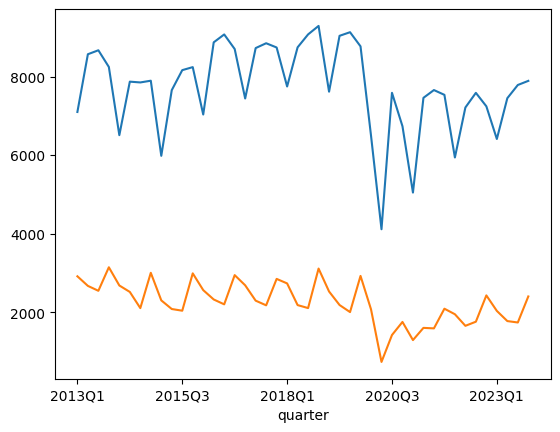

In [258]:
# visualizing general trends (total collisions with death/ injury vs just pedestrian incidents)

quarterly_outcomes = merged_w_intersections.drop_duplicates(subset=['collision_id']).groupby('quarter').agg({'pedestrian_death_or_injury':'sum','collision_id':'count'}).rename(columns={'collision_id':'total_death_or_injury'}).loc['2013Q1':'2023Q4']

quarterly_outcomes['total_death_or_injury'].plot()
quarterly_outcomes['pedestrian_death_or_injury'].plot()

<Axes: xlabel='quarter'>

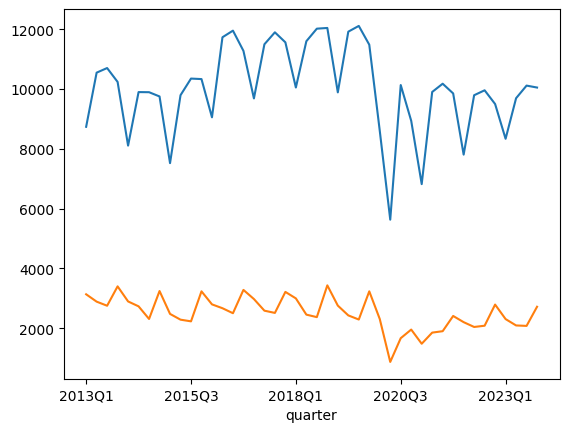

In [257]:
# comparing to unaltered Open Data collisions dataset, just to ensure that all the cleaning didn't artificially affect trends
# pattern looks the same, just lower overall total, which makes sense/ is reassuring (any collisions dropped for whatever reason aren't skewing the trends)

open_data_veh_collisions['total_injuries'] = open_data_veh_collisions['number_of_pedestrians_injured'] + open_data_veh_collisions['number_of_cyclist_injured'] + open_data_veh_collisions['number_of_motorist_injured']
open_data_veh_collisions['total_deaths'] = open_data_veh_collisions['number_of_pedestrians_killed'] + open_data_veh_collisions['number_of_cyclist_killed'] + open_data_veh_collisions['number_of_motorist_injured']
open_data_veh_collisions = open_data_veh_collisions[(open_data_veh_collisions['total_injuries'] > 0) | (open_data_veh_collisions['total_deaths'] > 0)]
open_data_veh_collisions['pedestrian_death_or_injury'] = open_data_veh_collisions['number_of_pedestrians_injured'] + open_data_veh_collisions['number_of_pedestrians_killed']
quarterly_outcomes = open_data_veh_collisions.drop(columns=['crash_date', 'crash_time']).groupby('quarter').agg({'pedestrian_death_or_injury':'sum','collision_id':'count'}).rename(columns={'collision_id':'total_death_or_injury'}).loc['2013Q1':'2023Q4']
quarterly_outcomes['total_death_or_injury'].plot()
quarterly_outcomes['pedestrian_death_or_injury'].plot()

In [253]:
# locating collision_ids associated with varying numbers of streets

num = 48
streets_per_crash = pd.DataFrame(merged_w_intersections['collision_id'].value_counts())
streets_per_crash[streets_per_crash['count'] == num]

,count
collision_id,
86945.0,48
3877184.0,48
3645817.0,48
87999.0,48
4317018.0,48
...,...
87709.0,48
4732369.0,48
4214581.0,48


In [254]:
# visualizing those matched to many streets to search for any issues 

id = 4408189
merged_w_intersections['street_geom'] = merged_w_intersections['street_geom'].apply(wkt.loads)
df = gpd.GeoDataFrame(merged_w_intersections, geometry='street_geom', crs="EPSG:2263")
m = df[df['collision_id']==id].drop_duplicates().explore(color='red')
df = gpd.GeoDataFrame(merged_w_intersections, geometry='intersection_geom', crs="EPSG:2263")
n = df[df['collision_id']==id].drop_duplicates().explore(m=m, color='green')
df = gpd.GeoDataFrame(merged_w_intersections, geometry='master_geom', crs="EPSG:2263")
df[df['collision_id']==id].drop_duplicates().explore(m=n, color='blue')


In [255]:
# visualizing 2017Q1 crashes
# doesn't seem like any crashes fall into highways, which is a sign the data is correct

gdf_intersections = merged_w_intersections.set_geometry('intersection_geom')
m = gdf_intersections[gdf_intersections['quarter'] == '2017Q1'].drop_duplicates(subset=['intersection_geom']).reset_index().loc[0:100] \
    .drop(columns=['crash_date','master_geom','street_geom']) \
    .explore(color='green')

gdf_nodes = merged_w_intersections.set_geometry('master_geom')
gdf_nodes[gdf_nodes['quarter'] == '2017Q1'].drop_duplicates(subset=['intersection_geom']).reset_index().loc[0:100] \
    .drop(columns=['crash_date','intersection_geom','street_geom']) \
    .explore(m=m, color='blue')

In [256]:
# download

merged_w_intersections.to_csv('../data/output/collisions-merged-with-intersections.csv', index=False)